# Lightweight Fine-Tuning Project

### Fine Tune BERT for Sentiment Classification


* PEFT technique: Adapters, LoRA and QLoRA
* Model: bert-base-uncased ~110M parameters
     - bert-base-uncased is a encoder-only architecture LLM that is apt for sentiment analysis while GPT2 which is decoder-only is not ideal for discriminative task like sentiment analysis.
     - bert-base-uncased will also fit comfortably in the Tesla T4 Udacity servers we students get.
     
* Evaluation approach: Accuracy, F1 Score and Confusion matrix
* Fine-tuning dataset: subsample of stanfordnlp/imdb - "IMDB movie reviews"

### About the Dataset

- Name: stanfordnlp/imdb

- Desc: Description: Large Movie Review Dataset. This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.
- Link: https://huggingface.co/datasets/stanfordnlp/imdb


## Loading and Evaluating a Foundation Model


In [2]:
import torch
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [71]:
# df to log experiment parameters
columns = ["Method",
        "Trainable Parameters (Mil)",
        "Trainable Parameters (%)",
        "Training Time / Epoch (s)",
        "Inference Time (s)",
        "ModelParams_GPUMemoryUsage (MB)",
        "PeakGPUMemoryUsage (MB)",
        "Accuracy",
        "F1 Score"]

explog_df = pd.DataFrame(columns = columns)

In [5]:
#Helper : source:https://huggingface.co/docs/transformers/main/en/quantization/bitsandbytes

def calc_trainable_parameters(model):
    """
    Calculate the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            
    return (all_param, trainable_params,100 * trainable_params / all_param)

In [6]:
#Helper Function to print conf matrix
def plot_confusion_matrix(y_true, y_pred, name):
    """
    Plot a custom-labeled confusion matrix heatmap.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Custom labels
    label_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    label_counts = ["{0:0.0f}".format(val) for val in conf_matrix.flatten()]
    labels = [f"{n}\n{c}" for n, c in zip(label_names, label_counts)]
    labels = np.array(labels).reshape(2, 2)

    # Plot
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

In [7]:
# Number of Epochs for Training each model
num_epoch = 3

### Load Dataset and EDA
We'll use the Hugging Face datasets library to load the dataset.

In [8]:
from datasets import load_dataset

# Load dataset
dataset = load_dataset("stanfordnlp/imdb")

In [9]:
df_train = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])

df_train.rename(columns={"label":'labels'}, inplace=True) #For Trainer compatibility
df_test.rename(columns={"label":'labels'}, inplace=True)

---

In [10]:
# Review lengths
df_train['length'] = df_train['text'].apply(lambda x: len(x.split()))

print("\nReview Length Stats:")
print(df_train['length'].describe())


Review Length Stats:
count    25000.000000
mean       233.787200
std        173.733032
min         10.000000
25%        127.000000
50%        174.000000
75%        284.000000
max       2470.000000
Name: length, dtype: float64


In [11]:
# Review lengths
df_test['length'] = df_test['text'].apply(lambda x: len(x.split()))

print("\nReview Length Stats:")
print(df_test['length'].describe())


Review Length Stats:
count    25000.000000
mean       228.526680
std        168.883693
min          4.000000
25%        126.000000
50%        172.000000
75%        277.000000
max       2278.000000
Name: length, dtype: float64


In [12]:
df_train[df_train['length'] < 25].tail(5)

,text,labels,length
16689,Obviously written for the stage. Lightweight b...,1,20
17069,Adrian Pasdar is excellent is this film. He ma...,1,12
20674,Brilliant movie. The drawings were just amazin...,1,23
21158,Excellent episode movie ala Pulp Fiction. 7 da...,1,24
23206,This movie will always be a Broadway and Movie...,1,22


In [13]:
# Class Distribution
class_counts = df_train['labels'].value_counts()
print("Class Distribution:\n", class_counts)

Class Distribution:
 labels
0    12500
1    12500
Name: count, dtype: int64


In [14]:
df_train['length'].quantile(0.85), df_test['length'].quantile(0.85)

(376.0, 368.0)

In [15]:
df_train.shape

(25000, 3)

### Sub-Sampling

- BERT model Context window size / Max sequence length is 512 and so any input greater than 512 tokens gets truncated hence we need to preprocess data to fit this constraint. 
- Each word gets tokenized on average into 3 to 4 subwords by the subword tokenization process and hence 512 / 1.4 = 365 words.  - Hence removing all reviews that are greater than 365 words to fit the BERT Context window size

In [16]:
df_train = df_train[df_train['length'] < 365]
df_test = df_test[df_test['length'] < 365]

In [17]:
df_train.head(2)

,text,labels,length
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,288
1,"""I Am Curious: Yellow"" is a risible and preten...",0,214


In [18]:
df_train.shape

(20990, 3)

#### Stratified Sampling - Keep class balance equal

In [19]:
from sklearn.model_selection import train_test_split

# Sample size per class
samples_per_class = 2500

# Stratified sampling
df_train_sampled, _ = train_test_split(
    df_train,
    stratify=df_train['labels'],
    train_size=samples_per_class * 2,  # total size
    random_state=42
)

df_test_sampled, _ = train_test_split(
    df_test,
    stratify=df_test['labels'],
    train_size=samples_per_class * 2,  # total size
    random_state=42
)

# Class Distribution
print("Sampled Class Distribution:")
print(df_train_sampled['labels'].value_counts(),df_test_sampled['labels'].value_counts() )


Sampled Class Distribution:
labels
0    2524
1    2476
Name: count, dtype: int64 labels
0    2510
1    2490
Name: count, dtype: int64


In [20]:
df_train_sampled.head(2)

,text,labels,length
607,PROS: Akshay Kumar's performance(is it just me...,0,355
20582,The brilliance of this movie is that even a co...,1,146


In [21]:
df_test_sampled.head(2)

,text,labels,length
1935,This was the most uninteresting horror flick I...,0,146
21148,Although copies of this movie are hard to find...,1,108


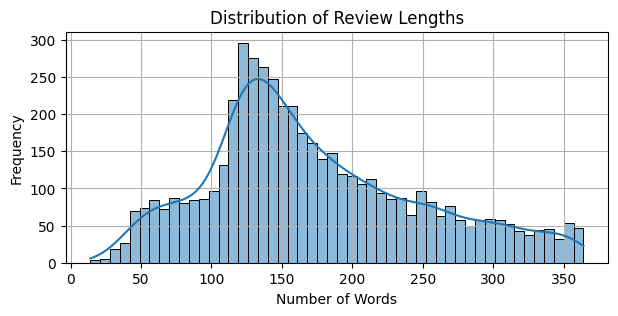

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 3))
sns.histplot(df_train_sampled['length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### Tokenize Samples

- BERT is a its encoder-type. Hence it has bidirectional attention which requires an attention mask which help it differentiate which token to focus (like a word/subword) and which to neglect (padding). Hence the Tokenizer for BERT creates input_ids + attention_mask. 
- attention_mask is simply binary with 1s and 0s indicating which to focus and which to neglect. 
- Input that are too short must be padded with 0s to fit BERT's context window size of 512 tokens.

In [23]:
from datasets import Dataset

# Convert DataFrames to Hugging Face datasets
train_dataset= Dataset.from_pandas(df_train_sampled)
test_dataset = Dataset.from_pandas(df_test_sampled)

In [24]:
from transformers import AutoTokenizer

# Instantiate Tokenizer - prepares the dataset into input IDs and attention masks.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")  

def tokenize_fn(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=512)

 - Note: Input text gets truncated to fit BERT Context window size hence we might as well remove all text greater than 512 tokens if they are not a big chunk of the dataset

In [25]:
# tokenize dataset
# Huggingface datasets.Dataset method that applied func in batches and adds new columns ids and attn_mask to dataset
tokenized_train = train_dataset.map(tokenize_fn, batched=True)
tokenized_test = test_dataset.map(tokenize_fn, batched=True)

# Convert to tensors
# Pytorch expects tensors hence conversion
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_test.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [26]:
# save tokenizer
# not necessary since tokenizer is not changed but doing as good practice
tokenizer.save_pretrained("./saved_models")

('./saved_models/tokenizer_config.json',
 './saved_models/special_tokens_map.json',
 './saved_models/vocab.txt',
 './saved_models/added_tokens.json',
 './saved_models/tokenizer.json')

---

## Baseline: BERT (Pre-Fine Tuning Evaluation)

BERT (bert-base-uncased) is a encoder-only architecture LLM that is apt for sentiment analysis. Before fine-tuning it for sequence classification, we need to check its zero-shot performance.

In [27]:
from transformers import AutoModelForSequenceClassification
from datasets import Dataset

# Pre-trained tokenizer and model
model_name = "bert-base-uncased"
model_baseline = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model_baseline.eval()
model_baseline.cuda()

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [28]:
weights_mem_baseline = model_baseline.get_memory_footprint() / (1024 ** 2)
print("Baseline Model Stats")
print(f"Model Weights memory footprint: {weights_mem_baseline} MB")

trainable_params = calc_trainable_parameters(model_baseline)
all_bl, train_bl, trainable_bl, = trainable_params[0], trainable_params[1], trainable_params[2]
print(f" All params: {all_bl} || Trainable params: {train_bl} || trainable%: {trainable_bl}" )

Baseline Model Stats
Model Weights memory footprint: 417.65528106689453 MB
 All params: 109483778 || Trainable params: 109483778 || trainable%: 100.0


### Run the Model (Zero-Shot) and Evaluate
- Zero shoting with pre-trained BERT as is without any fine-tuning. 
- Taking manual approach to define each step for learning. Pytorch Trainer which will used later does all below for us.


In [29]:
start_time = time.time()

# Zero-shot inference manually (without using Pytorch Trainer)
dataloader = torch.utils.data.DataLoader(tokenized_test, batch_size=32)

y_pred_bert = []
y_true_bert = []

with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cuda()

        outputs = model_baseline(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        y_pred_bert.extend(preds.cpu().tolist())
        y_true_bert.extend(labels.cpu().tolist())
        
end_time = time.time()
inference_time  = end_time - start_time
print(f"Zero-shot Inference time: {(inference_time ):.2f} seconds")


Zero-shot Inference time: 166.22 seconds


In [30]:
# Accuracy and F1
acc = accuracy_score(y_true_bert, y_pred_bert)
f1 = f1_score(y_true_bert, y_pred_bert)

print(f"Zero-shot Accuracy: {acc:.4f}")
print(f"Zero-shot F1 Score: {f1:.4f}")

Zero-shot Accuracy: 0.5422
Zero-shot F1 Score: 0.6565


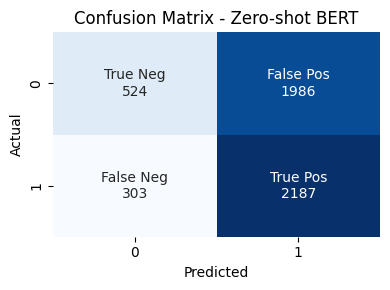

In [31]:
plot_confusion_matrix(y_true_bert,y_pred_bert, "Zero-shot BERT" )

In [32]:
explog_df.loc[len(explog_df)] = {
    "Method": "Zero-shot (Baseline)",
    "Trainable Parameters (Mil)": 110,
    "Trainable Parameters (%)": 100,
    "Inference Time (s)": round(inference_time, 2),
    "Accuracy": round(acc, 4),
    "F1 Score": round(f1, 4),
    "Training Time / Epoch (s)" : "NA",
    "ModelParams_GPUMemoryUsage (MB)" : round(weights_mem_baseline,2),
    "PeakGPUMemoryUsage (MB)": "NA"
}

explog_df

,Method,Trainable Parameters (Mil),Trainable Parameters (%),Training Time / Epoch (s),Inference Time (s),ModelParams_GPUMemoryUsage (MB),PeakGPUMemoryUsage (MB),Accuracy,F1 Score
0,Zero-shot (Baseline),110,100,NA,166.22,417.66,NA,0.5422,0.6565
